In [2]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
  Using cached plotly-6.3.1-py3-none-any.whl.metadata (8.5 kB)
Using cached plotly-6.3.1-py3-none-any.whl (9.8 MB)

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ------------------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
# ============================================================
# 1. Import required libraries
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings("ignore")

# Models
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import xgboost as xgb

In [4]:
# ============================================================
# 2. Load dataset
# ============================================================

df = pd.read_csv(r"C:\Users\sindh\OneDrive\Desktop\infosys practice\air_quality.csv", parse_dates=True, index_col=0)
df = df.sort_index()

# Example: choose a pollutant column
target_col = "PM2.5"  # <-- change as per your dataset
data = df[[target_col]].dropna()

# Split train/test
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [5]:
# ============================================================
# 3. ARIMA Model
# ============================================================

arima_model = ARIMA(train, order=(3, 1, 2))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

mae_arima = mean_absolute_error(test, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test, arima_forecast))

print(f"ARIMA → MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}")

ARIMA → MAE: 67.631, RMSE: 77.712


In [6]:
# ============================================================
# 4. Prophet Model
# ============================================================

prophet_df = data.reset_index()
prophet_df.columns = ['ds', 'y']

train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

prophet_model = Prophet()
prophet_model.fit(train_prophet)
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast = prophet_model.predict(future)

prophet_forecast = forecast['yhat'].iloc[-len(test):].values
mae_prophet = mean_absolute_error(test[target_col].values, prophet_forecast)
rmse_prophet = np.sqrt(mean_squared_error(test[target_col].values, prophet_forecast))

print(f"Prophet → MAE: {mae_prophet:.3f}, RMSE: {rmse_prophet:.3f}")

17:24:35 - cmdstanpy - INFO - Chain [1] start processing
17:24:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet → MAE: 67.629, RMSE: 79.293


In [7]:
# ============================================================
# 5. LSTM Model
# ============================================================

# Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

n_input = 10
n_features = 1

generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=16)

lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(n_input, n_features)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(generator, epochs=20, verbose=0)

# Forecast
predictions = []
batch = train_scaled[-n_input:].reshape((1, n_input, n_features))
for i in range(len(test)):
    pred = lstm_model.predict(batch, verbose=0)[0]
    predictions.append(pred)
    batch = np.append(batch[:, 1:, :], [[pred]], axis=1)

lstm_forecast = scaler.inverse_transform(predictions).ravel()
mae_lstm = mean_absolute_error(test[target_col], lstm_forecast)
rmse_lstm = np.sqrt(mean_squared_error(test[target_col], lstm_forecast))

print(f"LSTM → MAE: {mae_lstm:.3f}, RMSE: {rmse_lstm:.3f}")

LSTM → MAE: 66.066, RMSE: 77.816


In [8]:
# ============================================================
# 6. XGBoost with Lag Features
# ============================================================

def create_lag_features(df, n_lags=5):
    for i in range(1, n_lags+1):
        df[f'lag_{i}'] = df[target_col].shift(i)
    return df.dropna()

xgb_data = create_lag_features(data.copy(), 5)
X = xgb_data.drop(columns=[target_col])
y = xgb_data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))

print(f"XGBoost → MAE: {mae_xgb:.3f}, RMSE: {rmse_xgb:.3f}")

XGBoost → MAE: 76.401, RMSE: 91.941


In [9]:

# ============================================================
# 7. Model Comparison
# ============================================================

results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "LSTM", "XGBoost"],
    "MAE": [mae_arima, mae_prophet, mae_lstm, mae_xgb],
    "RMSE": [rmse_arima, rmse_prophet, rmse_lstm, rmse_xgb]
}).sort_values(by="RMSE")

print("\nModel Performance Comparison:\n", results)

best_model_name = results.iloc[0]["Model"]
print(f"\n✅ Best performing model: {best_model_name}")

# Save best model
if best_model_name == "ARIMA":
    joblib.dump(arima_fit, "best_model_arima.pkl")
elif best_model_name == "Prophet":
    joblib.dump(prophet_model, "best_model_prophet.pkl")
elif best_model_name == "LSTM":
    lstm_model.save("best_model_lstm.h5")
else:
    joblib.dump(xgb_model, "best_model_xgb.pkl")

print("📦 Best model saved successfully.")


Model Performance Comparison:
      Model        MAE       RMSE
0    ARIMA  67.631074  77.711600
2     LSTM  66.066314  77.815688
1  Prophet  67.628715  79.292626
3  XGBoost  76.400871  91.940695

✅ Best performing model: ARIMA
📦 Best model saved successfully.



🔍 Model Performance Comparison:
     Model        MAE       RMSE
0    ARIMA  67.631074  77.711600
2     LSTM  66.066314  77.815688
1  Prophet  67.628715  79.292626
3  XGBoost  76.400871  91.940695

✅ Best performing model: ARIMA


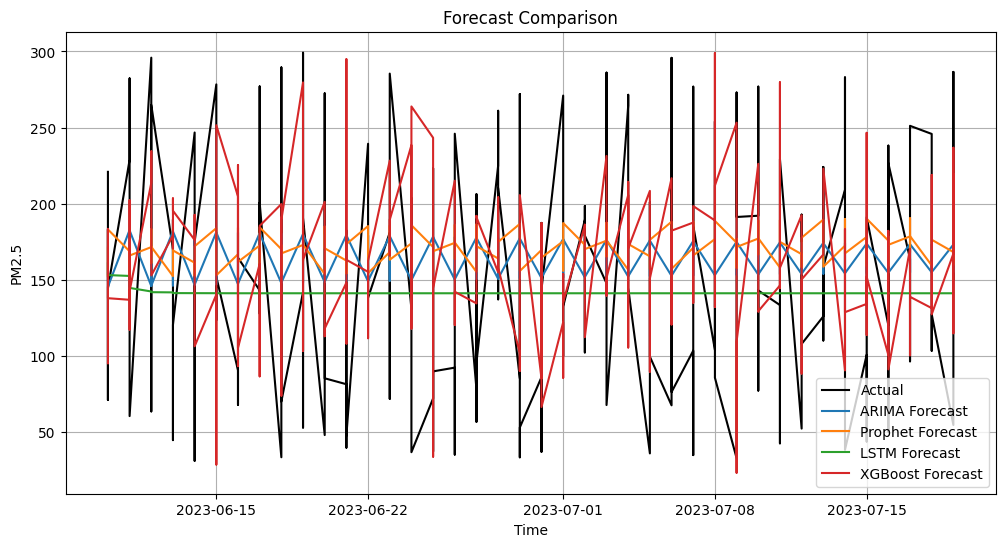

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you already have: test (true values) and forecasts from each model
results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "LSTM", "XGBoost"],
    "MAE": [mae_arima, mae_prophet, mae_lstm, mae_xgb],
    "RMSE": [rmse_arima, rmse_prophet, rmse_lstm, rmse_xgb]
}).sort_values(by="RMSE")

print("\n🔍 Model Performance Comparison:")
print(results)

# Best Model
best_model_name = results.iloc[0]["Model"]
print(f"\n✅ Best performing model: {best_model_name}")

# Plot forecasts
plt.figure(figsize=(12,6))
plt.plot(test.index, test[target_col], label="Actual", color="black")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.plot(test.index, prophet_forecast, label="Prophet Forecast")
plt.plot(test.index, lstm_forecast, label="LSTM Forecast")
plt.plot(y_test.index, xgb_pred, label="XGBoost Forecast")
plt.title("Forecast Comparison")
plt.xlabel("Time")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
for location in df['city'].unique():
    sub_df = df[df['city'] == location]
    print(f"\n📍 Training model for {location}...")
    # Repeat the ARIMA / Prophet / LSTM / XGBoost pipeline here

KeyError: 'city'

In [12]:
import joblib

if best_model_name == "ARIMA":
    joblib.dump(arima_fit, "best_model_arima.pkl")
elif best_model_name == "Prophet":
    joblib.dump(prophet_model, "best_model_prophet.pkl")
elif best_model_name == "LSTM":
    lstm_model.save("best_model_lstm.h5")
else:
    joblib.dump(xgb_model, "best_model_xgb.pkl")

print("📦 Best model saved successfully for future inference.")

📦 Best model saved successfully for future inference.
